# MultiVAE for Collaborative Filtering

# 1. 모듈 load

In [1]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

#import seaborn as sn
#sn.set()

import pandas as pd

import tensorflow as tf

In [2]:
print("tensorflow version: ", tf.__version__)

tensorflow version:  2.7.0


In [3]:
"""gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)"""

"gpu_info = !nvidia-smi\ngpu_info = '\n'.join(gpu_info)\nif gpu_info.find('failed') >= 0:\n    print('Not connected to a GPU')\nelse:\n    print(gpu_info)"

In [4]:
"""from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')"""

"from psutil import virtual_memory\nram_gb = virtual_memory().total / 1e9\nprint('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))\n\nif ram_gb < 20:\n    print('Not using a high-RAM runtime')\nelse:\n    print('You are using a high-RAM runtime!')"

# 2. 데이터 로드

In [5]:
def ply_by_songs(data):
    dataset = data[['id', 'songs']]
    dataset = dataset.sort_values(by='id', ascending=True)
    dataset_split = dataset.explode('songs')
    dataset_split = dataset_split.reset_index(drop=True)
    return dataset_split

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [8]:
DATA_DIR_RAW = './data/raw' # 디렉토리 설정
raw_data = pd.read_json(os.path.join(DATA_DIR_RAW, 'train.json'),typ = 'frame')

In [9]:
n_songs = int(max(ply_by_songs(raw_data)['songs'])+1)
n_ply = len(pd.unique(raw_data['id']))

In [10]:
n_songs, n_ply

(707989, 115071)

## 2-1. 데이터 Split

In [11]:
unique_id = pd.unique(raw_data['id'])

np.random.seed(98765)
idx_perm = np.random.permutation(unique_id.size) # 랜덤으로 섞기
unique_id = unique_id[idx_perm]

n_ply = unique_id.size
n_heldout_ply = 10000

train_id = unique_id[:(n_ply - n_heldout_ply * 3)]
valid_id = unique_id[(n_ply - n_heldout_ply * 3):(n_ply - n_heldout_ply)]
test_id = unique_id[(n_ply - n_heldout_ply):]

In [12]:
train_data = ply_by_songs(raw_data.loc[raw_data['id'].isin(train_id)])

In [13]:
def get_count(data, id):
    count_byid = data[[id]].groupby(id, as_index=False)
    count = count_byid.size()
    return count

# 필터링 코드
def filter_triplets(data, id, min_uc=10, min_sc=0):
    # min_sc: min_sc개 미만으로 포함되어 있는 노래 삭제
    if min_sc > 0:
        songs_count = get_count(data, id)
        data = data[data[id].isin(data.index[songs_count['size'] >= min_sc])]

    # min_pc: 노래가 min_pc 개 미만인 플레이리스트 삭제
    if min_uc > 0:
        ply_count = get_count(data, 'id')
        data = data[data['id'].isin(ply_count.index[ply_count['size'] >= min_uc])]
       
    # Update both usercount and itemcount after filtering
    ply_count, songs_count = get_count(data, 'id'), get_count(data, id) 
    return data, ply_count, songs_count

In [14]:
train_data, _, _ = filter_triplets(train_data, 'songs')
train_unique_songs = pd.unique(train_data['songs'])

In [15]:
valid_data = ply_by_songs(raw_data.loc[raw_data['id'].isin(valid_id)])
valid_data = valid_data.loc[valid_data['songs'].isin(train_unique_songs)]

In [16]:
test_data = ply_by_songs(raw_data.loc[raw_data['id'].isin(test_id)])
test_data = test_data.loc[test_data['songs'].isin(train_unique_songs)]

#### validation users & test users

In [17]:
def split_train_test_proportion(data, test_prop=0.2):
    data_grouped_by_ply = data.groupby('id')
    train, test = list(), list()

    np.random.seed(98765)
    for i, (_, group) in enumerate(data_grouped_by_ply):
        n_songs = len(group)

        if n_songs >= 5: # 플레이리스트에 5개가 넘는 노래가 있는 경우 0.2 비율로 랜덤으로 split
            idx = np.zeros(n_songs, dtype='bool')
            idx[np.random.choice(n_songs, size=int(test_prop * n_songs), replace=False).astype('int64')] = True

            train.append(group[np.logical_not(idx)])
            test.append(group[idx])
        else:
            train.append(group)

        if i % 1000 == 0:
            print("%d playlist sampled" % i)
            sys.stdout.flush()

    data_train = pd.concat(train)
    data_test = pd.concat(test)
    
    return data_train, data_test

In [18]:
valid_data_train, valid_data_test = split_train_test_proportion(valid_data)

0 playlist sampled
1000 playlist sampled
2000 playlist sampled
3000 playlist sampled
4000 playlist sampled
5000 playlist sampled
6000 playlist sampled
7000 playlist sampled
8000 playlist sampled
9000 playlist sampled
10000 playlist sampled
11000 playlist sampled
12000 playlist sampled
13000 playlist sampled
14000 playlist sampled
15000 playlist sampled
16000 playlist sampled
17000 playlist sampled
18000 playlist sampled
19000 playlist sampled


In [19]:
test_data_train, test_data_test = split_train_test_proportion(test_data)

0 playlist sampled
1000 playlist sampled
2000 playlist sampled
3000 playlist sampled
4000 playlist sampled
5000 playlist sampled
6000 playlist sampled
7000 playlist sampled
8000 playlist sampled
9000 playlist sampled


In [20]:
DATA_DIR = './data/preprocessed'

if not os.path.isdir(DATA_DIR):
    os.makedirs(DATA_DIR) 

In [21]:
train_data.to_csv(os.path.join(DATA_DIR, 'train.csv'), index=False)
valid_data_train.to_csv(os.path.join(DATA_DIR, 'validation_tr.csv'), index=False)
valid_data_test.to_csv(os.path.join(DATA_DIR, 'validation_te.csv'), index=False)
test_data_train.to_csv(os.path.join(DATA_DIR, 'test_tr.csv'), index=False)
test_data_test.to_csv(os.path.join(DATA_DIR, 'test_te.csv'), index=False)

## 2-2. 저장된 데이터 세트 불러오기

In [22]:
DATA_DIR = "./data/preprocessed"

In [23]:
def load_train_data(csv_file):
    data = pd.read_csv(csv_file)
    n_ply = data['id'].max() + 1

    rows, cols = data['id'], data['songs']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_ply, n_songs))
    return data

In [24]:
def load_train_test_data(csv_file_train, csv_file_test):
    data_train = pd.read_csv(csv_file_train)
    data_test = pd.read_csv(csv_file_test)

    start_idx = min(data_train['id'].min(), data_test['id'].min())
    end_idx = max(data_train['id'].max(), data_test['id'].max())

    rows_train, cols_train = data_train['id'] - start_idx, data_train['songs']
    rows_test, cols_test = data_test['id'] - start_idx, data_test['songs']

    data_train_split = sparse.csr_matrix((np.ones_like(rows_train),
                             (rows_train, cols_train)), dtype='float64', shape=(end_idx - start_idx + 1, n_songs))
    data_test_split = sparse.csr_matrix((np.ones_like(rows_test),
                             (rows_test, cols_test)), dtype='float64', shape=(end_idx - start_idx + 1, n_songs))
    return data_train_split, data_test_split

In [26]:
train_data = load_train_data(os.path.join(DATA_DIR, 'train.csv'))
valid_data_train, valid_data_test = load_train_test_data(os.path.join(DATA_DIR, 'validation_tr.csv'),
                                           os.path.join(DATA_DIR, 'validation_te.csv'))
test_data_train, test_data_test = load_train_test_data(os.path.join(DATA_DIR, 'test_tr.csv'),
                                             os.path.join(DATA_DIR, 'test_te.csv'))

In [27]:
train_data.nnz, valid_data_train.nnz, valid_data_test.nnz, test_data_train.nnz, test_data_test.nnz

(2109174, 670036, 157826, 336193, 79176)

# 3. Model 정의

#### 하이퍼 파라미터

In [28]:
N = train_data.shape[0] # 학습 세트 수
idxlist = np.arange(N)
batch_size = 1 # 학습 세트 배치 크기
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = valid_data_train.shape[0] # 검증 세트 수
idxlist_vad = range(N_vad) 
batch_size_vad = 1 # 검증 세트 배치 크기

N_test = test_data_train.shape[0] # 테스트 세트 수
idxlist_test = range(N_test)
batch_size_test = 1 # 테스트 세트 배치 크기

#total_anneal_steps = 200000 # annealing을 위한 gradient 업데이트 수
#anneal_cap = 0.2 # 논문 실험 결과, 가장 좋은 anneal 수치

n_epochs = 2 # epoch 수

#### 모델 & 평가지표 load

In [29]:
import sys
sys.path.append('./models')

from models import MultiDAE, MultiVAE
import evaluation_metrics as me

In [30]:
# DAE
p_dims = [200, n_songs]
dae = MultiDAE(p_dims, lam=0.01 / batch_size, dropout_prob = 0.5, random_seed=98765)
dae.compile(optimizer="adam", loss=dae.loss)

DAE_SAVE_DIR = './models/best_model' 
if not os.path.exists(DAE_SAVE_DIR):
    os.makedirs(DAE_SAVE_DIR)

In [32]:
dae.load_weights(os.path.join(DAE_SAVE_DIR, "best_dae_model"))

# 4. 학습

## 4-1. DAE 학습 & 평가

In [ ]:
ndcgs_valid = []
best_epoch = -1
best_ndcg = -np.inf

In [ ]:
for epoch in range(n_epochs):
    # 학습
    np.random.shuffle(idxlist)
    print("\ntrain loop")
    for step, st_idx in enumerate(range(0, N, batch_size)):
        end_idx = min(st_idx + batch_size, N)
        X = train_data[idxlist[st_idx:end_idx]]
        
        if X.nnz == 0:
            continue
        
        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')   
        
        dae.fit(X, verbose=0)
        break
        if step % 10 == 0:
          print(step, end=" ")

    # 검증 & NDCG
    ndcg_dist = []
    print("\nvalid loop")
    for step, st_idx in enumerate(range(0, N_vad, batch_size_vad)):
        end_idx = min(st_idx + batch_size_vad, N_vad)
        X = valid_data_train[idxlist_vad[st_idx:end_idx]]
        y = valid_data_test[idxlist_vad[st_idx:end_idx]]
        
        if X.nnz == 0 or y.nnz == 0:
            continue
        
        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')
    
        pred_val = dae.test(X)
        pred_val = pred_val.numpy()
        pred_val[X.nonzero()] = -np.inf # train에서 사용된 샘플 제외
        ndcg_dist.append(me.NDCG(pred_val, y, k=100))
        break
        if step % 10 == 0:
            print(step, end=" ")

    ndcg_dist = np.concatenate(ndcg_dist)
    ndcg_dist[np.isnan(ndcg_dist)]=0 ##Nan값 0으로 바꾸기
    ndcg_ = ndcg_dist.mean()
    ndcgs_valid.append(ndcg_)
    
    if ndcg_ > best_ndcg:
        best_epoch = epoch
        best_ndcg = ndcg_
        print(epoch, best_ndcg)
        dae.save_weights(os.path.join(DAE_SAVE_DIR, "best_dae_model")) # 모델 저장

In [7]:
# best: epoch 6
ndcgs_valid = [0.009, 0.010, 0.010491380946078174, 0.010551602153828415, 0.01066607815009429, 0.011066752336179165, 0.010591064504233064]

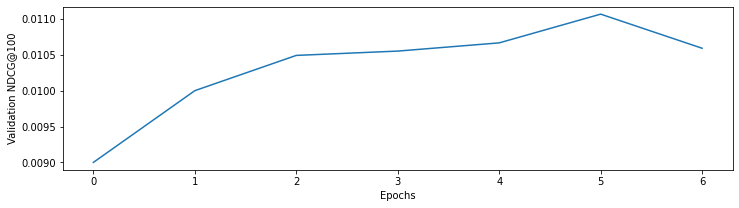

In [8]:
plt.figure(figsize=(12, 3))
plt.plot(ndcgs_valid)
plt.ylabel("Validation NDCG@100")
plt.xlabel("Epochs")
pass

### 평가

#### Best Model 로드

In [33]:
# DAE
p_dims = [200, n_songs]
best_dae = MultiDAE(p_dims, lam=0.01 / batch_size, dropout_prob = 0.5, random_seed=98765)
best_dae.compile(optimizer="adam", loss=dae.loss)

In [34]:
best_dae.load_weights(os.path.join(DAE_SAVE_DIR, "best_dae_model"))

In [17]:
n3000_list, r3000_list = [], []
n1000_list, r1000_list = [], []
n500_list, r500_list = [], []
n100_list, r100_list = [], []
    
for step, st_idx in enumerate(range(0, N_test, batch_size_test)):
    end_idx = min(st_idx + batch_size_test, N_test)
    X = test_data_train[idxlist_test[st_idx:end_idx]]
    y = test_data_test[idxlist_test[st_idx:end_idx]]
    
    if X.nnz == 0:
        continue
    
    if sparse.isspmatrix(X):
        X = X.toarray()
    X = X.astype('float32')

    pred_val = dae.test(X)
    pred_val = pred_val.numpy()
    pred_val[X.nonzero()] = -np.inf # 학습과정에서 쓴 샘플들 제외
    
    n3000_list.append(me.NDCG(pred_val, y, k=3000))
    r3000_list.append(me.Recall(pred_val, y, k=3000))

    n1000_list.append(me.NDCG(pred_val, y, k=1000))
    r1000_list.append(me.Recall(pred_val, y, k=1000))
    
    n500_list.append(me.NDCG(pred_val, y, k=500))
    r500_list.append(me.Recall(pred_val, y, k=500))
    
    n100_list.append(me.NDCG(pred_val,y, k=100))
    r100_list.append(me.Recall(pred_val, y, k=100))
    
    if step % 10 == 0:
        print(step, end=" ")

n3000_list = np.concatenate(n3000_list)
r3000_list = np.concatenate(r3000_list)
n1000_list = np.concatenate(n1000_list)
r1000_list = np.concatenate(r1000_list)
n500_list = np.concatenate(n500_list)
r500_list = np.concatenate(r500_list)
n100_list = np.concatenate(n100_list)
r100_list = np.concatenate(r100_list)

0 

C:\Users\gunso\Downloads\songs\./models\evaluation_metrics.py:28: RuntimeWarning: invalid value encountered in true_divide
  return DCG / IDCG
C:\Users\gunso\Downloads\songs\./models\evaluation_metrics.py:12: RuntimeWarning: invalid value encountered in true_divide
  recall = tmp / np.minimum(k, true_val.sum(axis=1))


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 

KeyboardInterrupt: 

In [18]:
##Nan값 0으로 바꾸기
n3000_list[np.isnan(n3000_list)]=0
r3000_list[np.isnan(r3000_list)]=0

n1000_list[np.isnan(n1000_list)]=0
r1000_list[np.isnan(r1000_list)]=0

n500_list[np.isnan(n500_list)]=0
r500_list[np.isnan(r500_list)]=0

n100_list[np.isnan(n100_list)]=0
r100_list[np.isnan(r100_list)]=0

TypeError: only integer scalar arrays can be converted to a scalar index

In [19]:
print("Test NDCG@3000=%.5f (%.5f)" % (np.mean(n3000_list), np.std(n3000_list) / np.sqrt(len(n3000_list))))
print("Test Recall@3000=%.5f (%.5f)\n" % (np.mean(r3000_list), np.std(r3000_list) / np.sqrt(len(r3000_list))))

print("Test NDCG@1000=%.5f (%.5f)" % (np.mean(n1000_list), np.std(n1000_list) / np.sqrt(len(n1000_list))))
print("Test Recall@1000=%.5f (%.5f)\n" % (np.mean(r1000_list), np.std(r1000_list) / np.sqrt(len(r1000_list))))

print("Test NDCG@500=%.5f (%.5f)" % (np.mean(n500_list), np.std(n500_list) / np.sqrt(len(n500_list))))
print("Test Recall@500=%.5f (%.5f)\n" % (np.mean(r500_list), np.std(r500_list) / np.sqrt(len(r500_list))))

print("Test NDCG@100=%.5f (%.5f)" % (np.mean(n100_list), np.std(n100_list) / np.sqrt(len(n100_list))))
print("Test Recall@100=%.5f (%.5f)\n" % (np.mean(r100_list), np.std(r100_list) / np.sqrt(len(r100_list))))

Test NDCG@3000=nan (nan)
Test Recall@3000=nan (nan)

Test NDCG@1000=nan (nan)
Test Recall@1000=nan (nan)

Test NDCG@500=nan (nan)
Test Recall@500=nan (nan)

Test NDCG@100=nan (nan)
Test Recall@100=nan (nan)



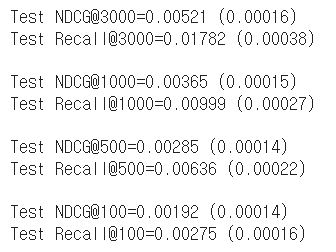

In [1]:
from IPython.display import Image
Image("result.JPG")

### 결과 확인

In [ ]:
SONG_RAW_DIR = './data/raw'
song_meta = pd.read_json(os.path.join(DIR, 'song_meta.json'),typ = 'frame')

X = test_data_train[0]
pred_val = best_dae.test(pred_val)

In [ ]:
X_t = np.transpose(np.nonzero(X))
song_meta.loc[X_t[:,1]]['song_name'][:10]

In [ ]:
pred_val_t = pred_val.numpy()
np.where(pred_val_t<0, 0, pred_val_t)
idx_topk_part = np.argsort(-pred_val_t[0])
print(song_meta.iloc[idx_topk_part]['song_name'])